goal: clean our messy dataset

In [31]:
import csv
import pandas as pd
df_pyktok = pd.read_csv('./pyktok_output.csv')

In [32]:
def determine_category(info):
    if type(info) == str:
        if 'sports' in info.lower() or 'fitness' in info.lower() or 'outdoor' in info.lower():
            return 'sports'
        elif 'beauty' in info.lower() or 'style' in info.lower():
            return 'beauty'
        elif 'society' in info.lower() or 'news' in info.lower() or 'social issues' in info.lower():
            return 'society'
        else:
            return 'other'
    else:
        return None
    
#label category    
df_pyktok['category'] = df_pyktok['diversificationLabels'].apply(determine_category)

In [33]:
category_counts = df_pyktok['category'].value_counts(dropna=False)
category_counts
#since there are only  148 none values, we'll manually look thru and check the categories
#df_pyktok.to_csv('./df_pyktok.csv')
df_pyktok = pd.read_csv('./df_pyktok.csv')

In [34]:
category_counts

category
other      1247
beauty      408
sports      199
society     195
None        148
Name: count, dtype: int64

In [35]:
link_to_category_dict = pd.Series(df_pyktok['category'].values, index=df_pyktok['video_id']).to_dict()
link_to_likes_dict = pd.Series(df_pyktok['video_diggcount'].values, index=df_pyktok['video_id']).to_dict()
link_to_author_dict = pd.Series(df_pyktok['author_username'].values, index=df_pyktok['video_id']).to_dict()

In [36]:
import json

with open('./original_merged_data.json') as f:
    dct_scraped = json.load(f)

dct_scraped[0]

{'distributed_link': 'https://www.tiktok.com/@_giannalove/video/7325171122000055598',
 'rec_links': {'beauty_rec_1': 'https://www.tiktok.com/@certified_hassan/video/7360247028833733893',
  'beauty_rec_2': 'https://www.tiktok.com/@nsw.trainvlogs/video/7360242264662199568',
  'beauty_rec_3': 'https://www.tiktok.com/@zachking/video/7338816875956030766',
  'beauty_rec_4': 'https://www.tiktok.com/@user1013040614268/video/7360258895568211205',
  'beauty_rec_5': 'https://www.tiktok.com/@riize_official/video/7360211842804796689',
  'beauty_rec_6': 'https://www.tiktok.com/@sugaritumanisss/video/7360387186988043525',
  'beauty_rec_7': 'https://www.tiktok.com/@_giannalove/video/7350718404279438634',
  'beauty_rec_8': 'https://www.tiktok.com/@deboraseoane/video/7360487735368502533',
  'sports_rec_1': 'https://www.tiktok.com/@wsgwitit20/video/7360386897736207624',
  'sports_rec_2': 'https://www.tiktok.com/@_giannalove/video/7350718404279438634',
  'sports_rec_3': 'https://www.tiktok.com/@itsyaboyau

In [37]:
df_pyktok['category'].value_counts(dropna = False)

category
other      1360
beauty      413
society     217
sports      204
NaN           3
Name: count, dtype: int64

In [40]:
#main code block
#we rebuild the dataset with the categories
rows = []
for item in dct_scraped:
    dst_id = item['distributed_link'].split('/')[-1].split('?')[0]
    dstr_category = None
    dstr_author = None
    
    try: #check if we have pyktok data for video
        dstr_category = link_to_category_dict[int(dst_id)]
        dstr_author = link_to_author_dict[int(dst_id)]
    except:
        pass
    
    for rec_type, rec_link in item['rec_links'].items():
        persona = rec_type.split('_')[0]
        rec_id = None
        rec_category = None
        rec_author = None
        rec_type = rec_type.replace("control_society_rec", 'control_rec')
        
        if rec_link:
            rec_id = rec_link.split('/')[-1].split('?')[0]
        
        try:
            rec_category = link_to_category_dict[int(rec_id)]
            rec_author = link_to_author_dict[int(rec_id)]
        except:
            pass
        
        rows.append({
                    'distributed_link_id': dst_id,
                    'distributed_link_author': dstr_author,
                    'distributed_link_category': dstr_category,
                    'persona_category': persona,
                    'rec_category': rec_category,
                    'rec_author': rec_author
                })


df_categorized_temp = pd.DataFrame(rows)

In [41]:
df_categorized = df_categorized_temp.groupby(
    ['distributed_link_id', 'persona_category']
).agg({
    'distributed_link_category':'first',
    'distributed_link_author':'first',
    'rec_category': list,  # List all categories
    'rec_author': list,
}).reset_index()



In [42]:
df_categorized

,distributed_link_id,persona_category,distributed_link_category,distributed_link_author,rec_category,rec_author
0,7238391829421395243,beauty,sports,leah.givestipss,"[other, None, None, None, None, None, None, None]","[rileyscallon, None, None, None, None, None, N..."
1,7238391829421395243,control,sports,leah.givestipss,"[sports, None, beauty, sports, other, beauty, ...","[denizms3_, None, good.creation, snookerchamp1..."
2,7238391829421395243,society,sports,leah.givestipss,"[other, other, other, society, other, other, o...","[johayn.jumma, millenaeli, manu.gutierre8, cbs..."
3,7238391829421395243,sports,sports,leah.givestipss,"[other, other, other, None, None, other, other...","[iamnzae, nonbeatsz, icafabria, None, None, ka..."
4,7287664074081586438,beauty,sports,taylerfit,"[sports, sports, sports, beauty, sports, sport...","[taylerfit, taylerfit, taylerfit, packjower, t..."
...,...,...,...,...,...,...
395,7357026311220612394,sports,society,the_inconvenient_truth88,"[sports, beauty, other, sports, other, sports,...","[notgracefuger, kxks.official, girlonset, ibra..."
396,7358538332013366570,beauty,society,msnbc,"[other, other, other, other, other, other, oth...","[donmahluvinlandrygame, uespiiiii.1115, megaam..."
397,7358538332013366570,control,society,msnbc,"[other, sports, sports, other, None, other, ot...","[steves.adventure, kazetskaya_mishka14, darkha..."
398,7358538332013366570,society,society,msnbc,"[other, society, None, other, other, society, ...","[mebye.15, sbsnews_au, None, filssawadog, quee..."


In [43]:
from collections import Counter

def analysis(row,target):
    """basic analysis of our data"""
    target_category = row[target]
    category_counts = Counter(row['rec_category'])
    highest_count = max(category_counts.values())
    top_categories = [category for category, count in category_counts.items() if count == highest_count]

    isTopCount = target_category in top_categories
    num_rec_author = sum(1 for rec in row['rec_author'] if rec != None)
    num_rec_category = sum(1 for rec in row['rec_category'] if rec != None)
    propCategory = 0
    propSameAuthor = 0
    if target_category != None:
            if num_rec_category:
                propCategory = (category_counts[target_category] / num_rec_category)
            if num_rec_author:
                propSameAuthor = Counter(row['rec_author'])[row['distributed_link_author']] / num_rec_author

    isMajorityCount = propCategory > 0.5
    isFirst3Position = target_category in row['rec_category'][:3]
    isFirstPosition = target_category == row['rec_category'][0]
    
    return isTopCount, propCategory, isMajorityCount,isFirst3Position, isFirstPosition, propSameAuthor

df_categorized[['isTopCount_persona','prop_persona', 'isMajorityCount_persona', 'isFirst3Position_persona', 'isFirstPosition_persona', 'propSameAuthor']] = df_categorized.apply(lambda row: analysis(row, 'persona_category'), axis=1, result_type='expand')
df_categorized[['isTopCount_dst','prop_dst', 'isMajorityCount_dst', 'isFirst3Position_dst', 'isFirstPosition_dst','propSameAuthor']] = df_categorized.apply(lambda row: analysis(row, 'distributed_link_category'), axis=1, result_type='expand')


In [44]:
df_categorized.to_csv('./cleaned.csv')

In [45]:
df_categorized

,distributed_link_id,persona_category,distributed_link_category,distributed_link_author,rec_category,rec_author,isTopCount_persona,prop_persona,isMajorityCount_persona,isFirst3Position_persona,isFirstPosition_persona,propSameAuthor,isTopCount_dst,prop_dst,isMajorityCount_dst,isFirst3Position_dst,isFirstPosition_dst
0,7238391829421395243,beauty,sports,leah.givestipss,"[other, None, None, None, None, None, None, None]","[rileyscallon, None, None, None, None, None, N...",False,0.000000,False,False,False,0.00,False,0.000000,False,False,False
1,7238391829421395243,control,sports,leah.givestipss,"[sports, None, beauty, sports, other, beauty, ...","[denizms3_, None, good.creation, snookerchamp1...",False,0.000000,False,False,False,0.00,True,0.571429,True,True,True
2,7238391829421395243,society,sports,leah.givestipss,"[other, other, other, society, other, other, o...","[johayn.jumma, millenaeli, manu.gutierre8, cbs...",False,0.125000,False,False,False,0.00,False,0.000000,False,False,False
3,7238391829421395243,sports,sports,leah.givestipss,"[other, other, other, None, None, other, other...","[iamnzae, nonbeatsz, icafabria, None, None, ka...",False,0.000000,False,False,False,0.00,False,0.000000,False,False,False
4,7287664074081586438,beauty,sports,taylerfit,"[sports, sports, sports, beauty, sports, sport...","[taylerfit, taylerfit, taylerfit, packjower, t...",False,0.125000,False,False,False,0.75,True,0.625000,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,7357026311220612394,sports,society,the_inconvenient_truth88,"[sports, beauty, other, sports, other, sports,...","[notgracefuger, kxks.official, girlonset, ibra...",True,0.571429,True,True,True,0.00,False,0.000000,False,False,False
396,7358538332013366570,beauty,society,msnbc,"[other, other, other, other, other, other, oth...","[donmahluvinlandrygame, uespiiiii.1115, megaam...",False,0.000000,False,False,False,0.00,False,0.000000,False,False,False
397,7358538332013366570,control,society,msnbc,"[other, sports, sports, other, None, other, ot...","[steves.adventure, kazetskaya_mishka14, darkha...",False,0.000000,False,False,False,0.00,False,0.000000,False,False,False
398,7358538332013366570,society,society,msnbc,"[other, society, None, other, other, society, ...","[mebye.15, sbsnews_au, None, filssawadog, quee...",False,0.400000,False,True,False,0.00,False,0.400000,False,True,False


Plots

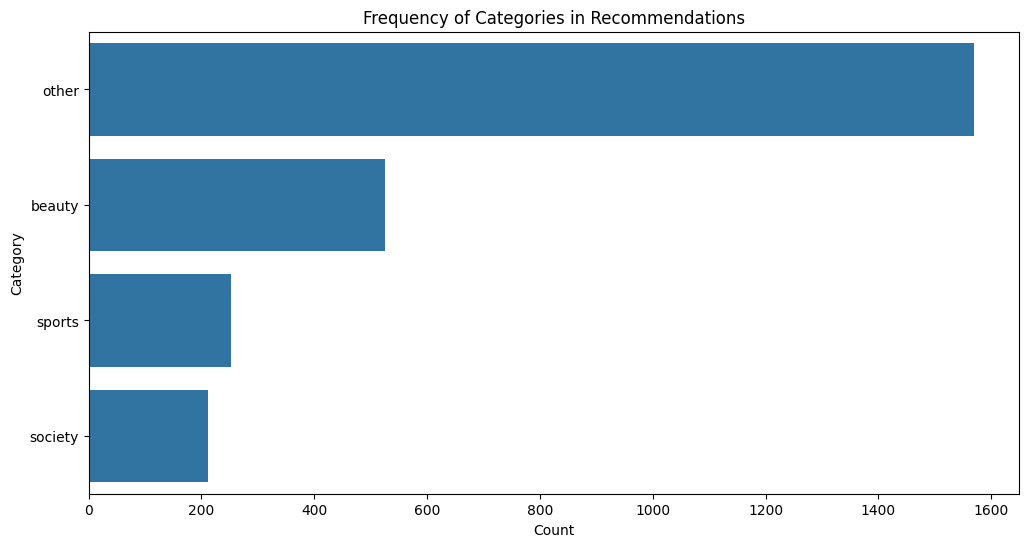

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns


all_categories = [category for sublist in df_categorized['rec_category'].tolist() for category in sublist if category is not None]
plt.figure(figsize=(12, 6))
sns.countplot(y=all_categories, order=pd.Series(all_categories).value_counts().index)
plt.title('Frequency of Categories in Recommendations')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

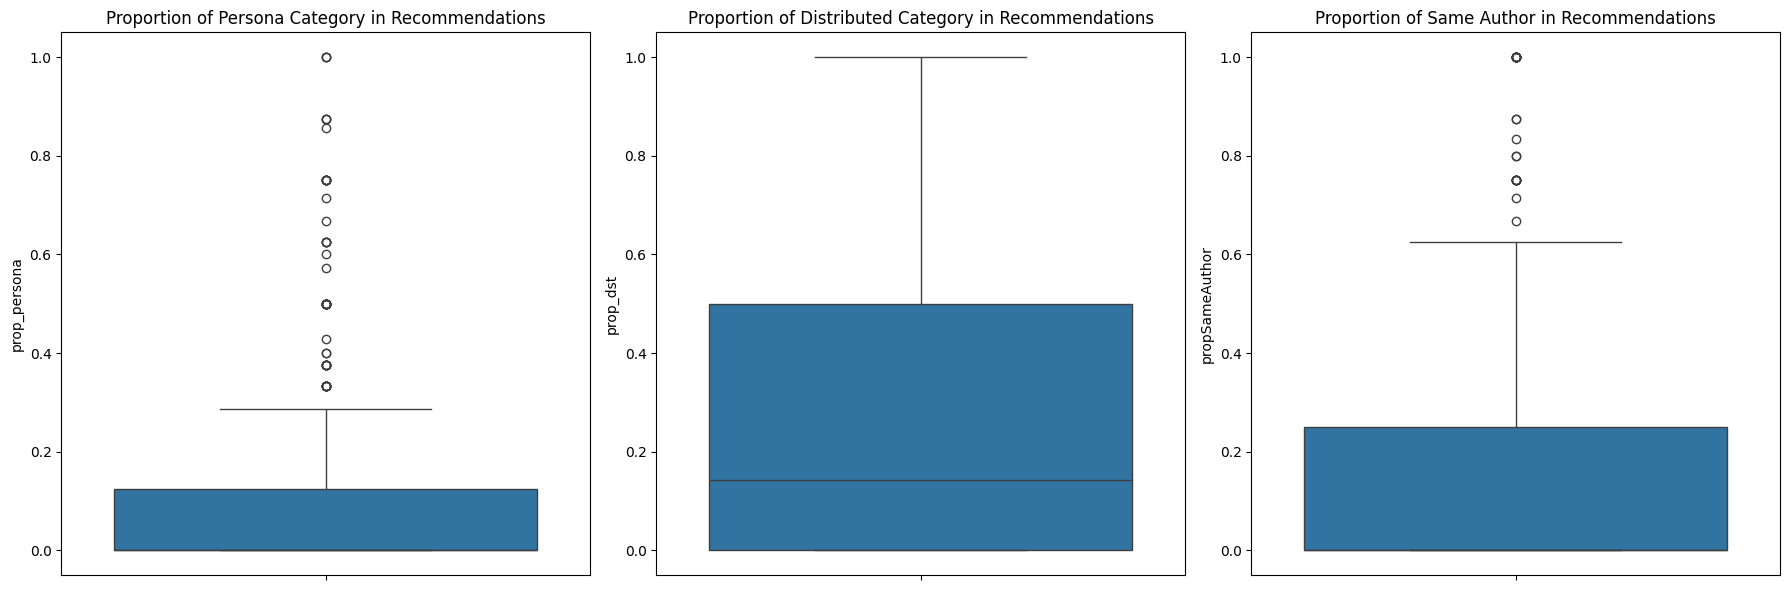

In [47]:
# Create a boxplot to explore the proportion properties
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
sns.boxplot(data=df_categorized, y='prop_persona', ax=axes[0]).set_title('Proportion of Persona Category in Recommendations')
sns.boxplot(data=df_categorized, y='prop_dst', ax=axes[1]).set_title('Proportion of Distributed Category in Recommendations')
sns.boxplot(data=df_categorized, y='propSameAuthor', ax=axes[2]).set_title('Proportion of Same Author in Recommendations')
plt.tight_layout()
plt.show()

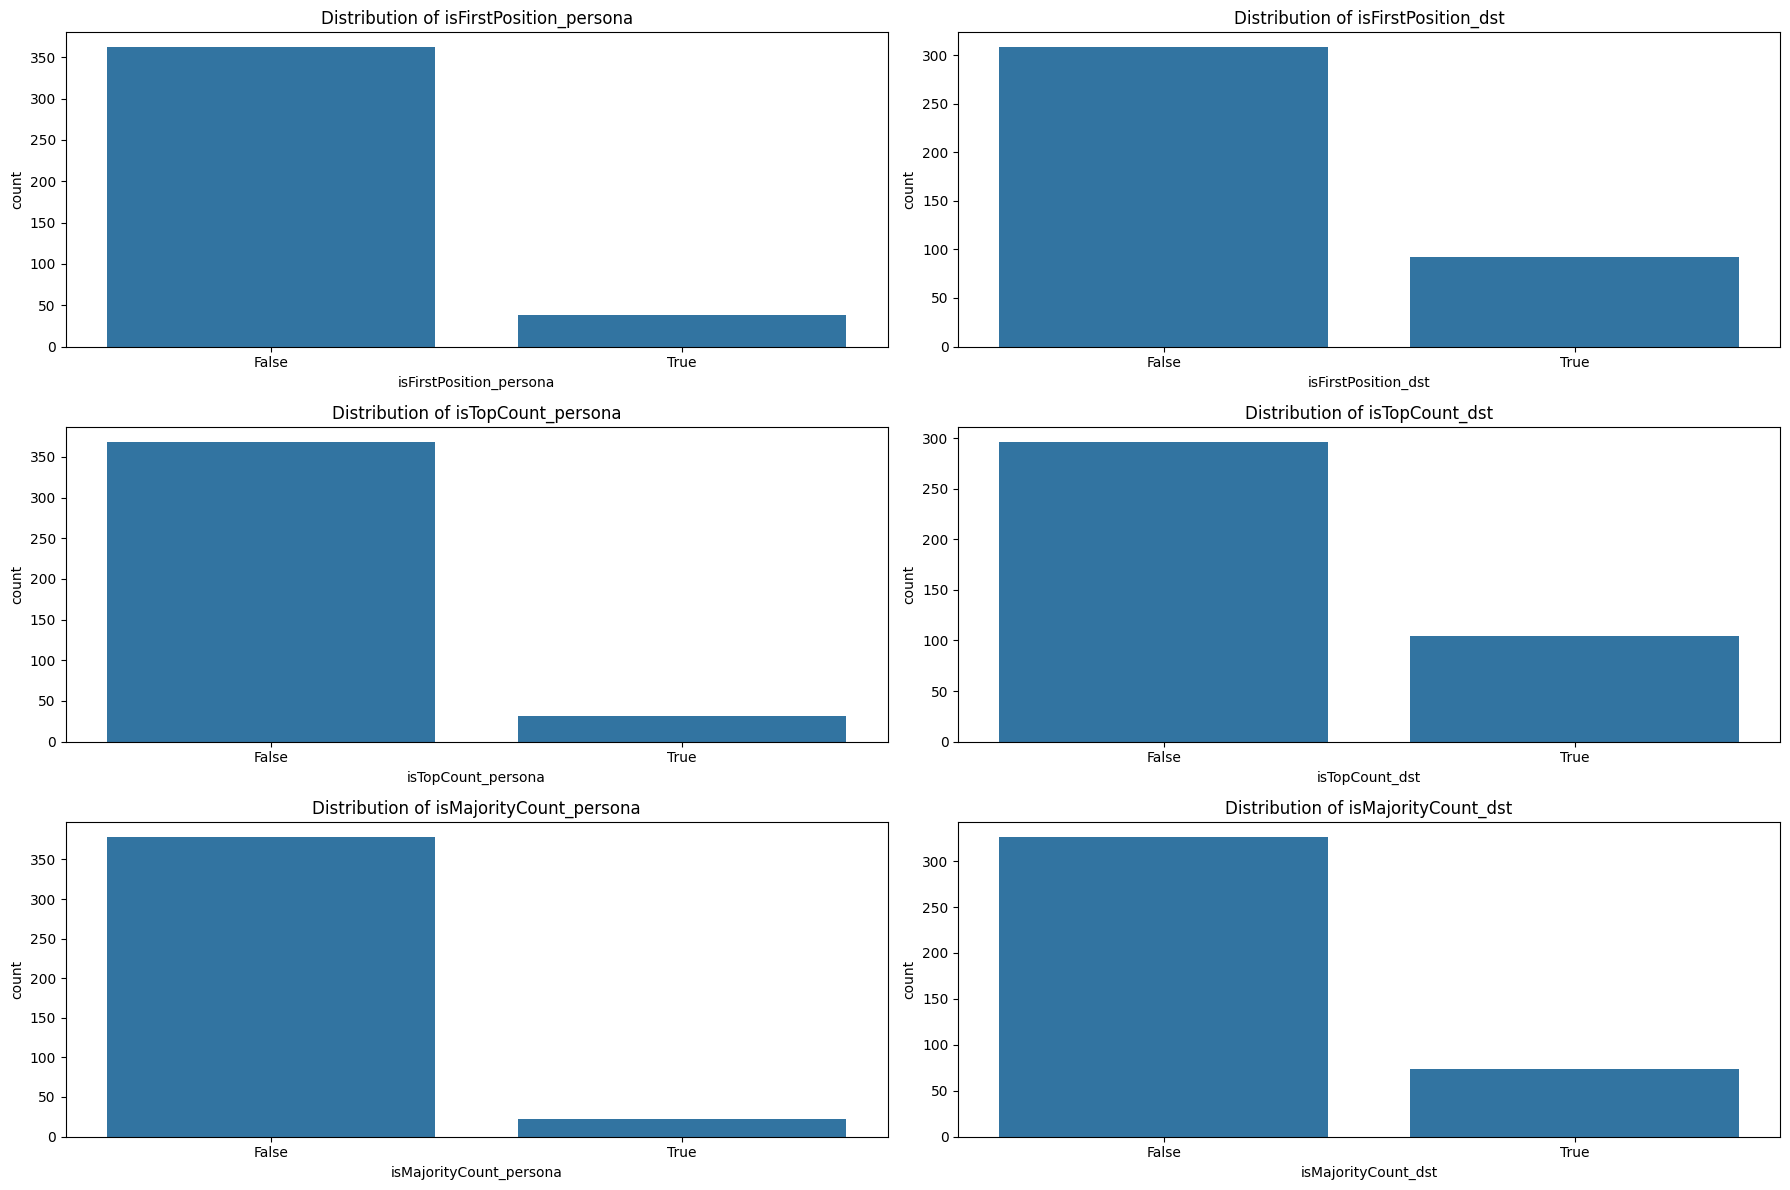

In [48]:
# Bar plots for boolean columns related to position and count
boolean_columns = ['isFirstPosition_persona', 'isFirstPosition_dst', 'isTopCount_persona', 'isTopCount_dst', 'isMajorityCount_persona', 'isMajorityCount_dst']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for idx, col in enumerate(boolean_columns):
    sns.countplot(data=df_categorized, x=col, ax=axes[idx//2, idx%2]).set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

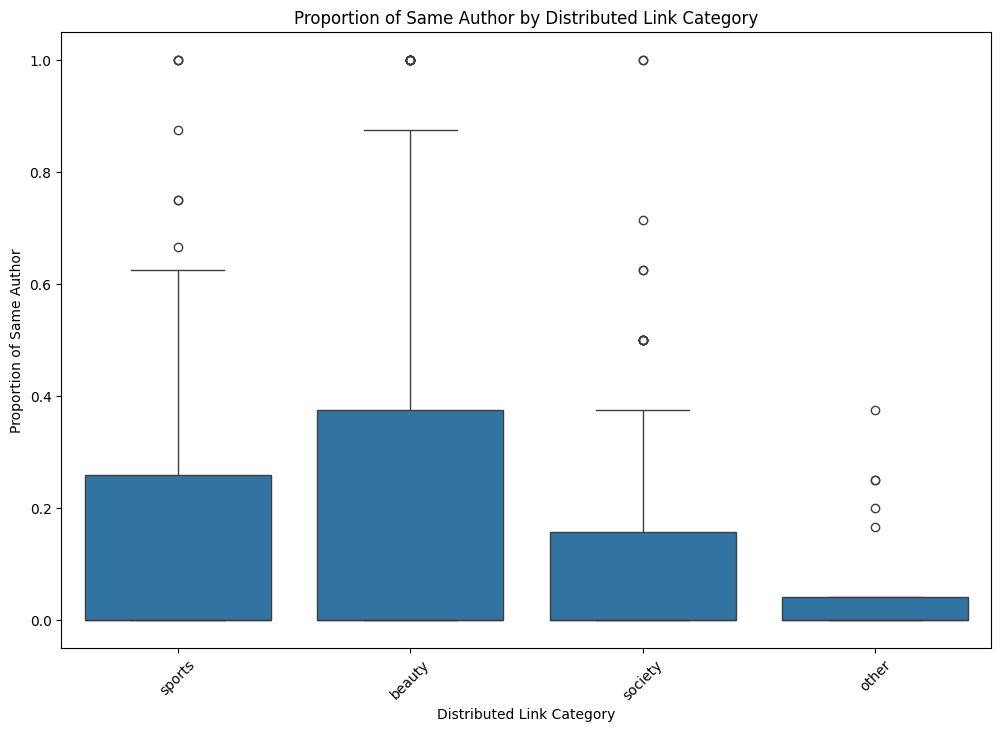

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='distributed_link_category', y='propSameAuthor', data=df_categorized)
plt.title('Proportion of Same Author by Distributed Link Category')
plt.xlabel('Distributed Link Category')
plt.ylabel('Proportion of Same Author')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.show()

In [19]:
df_filtered = df_categorized[df_categorized['persona_category'] != 'control']

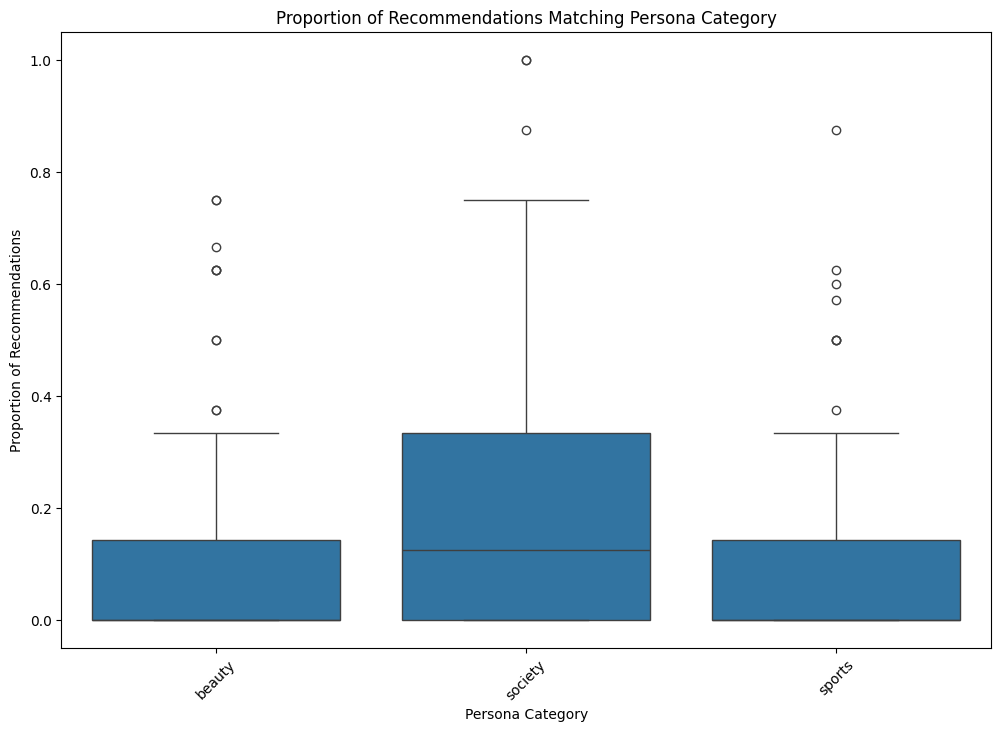

In [49]:
# Boxplot for the proportion of recommendations that match the persona's category, grouped by persona
plt.figure(figsize=(12, 8))
sns.boxplot(x='persona_category', y='prop_persona', data=df_filtered)
plt.title('Proportion of Recommendations Matching Persona Category')
plt.xlabel('Persona Category')
plt.ylabel('Proportion of Recommendations')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.show()

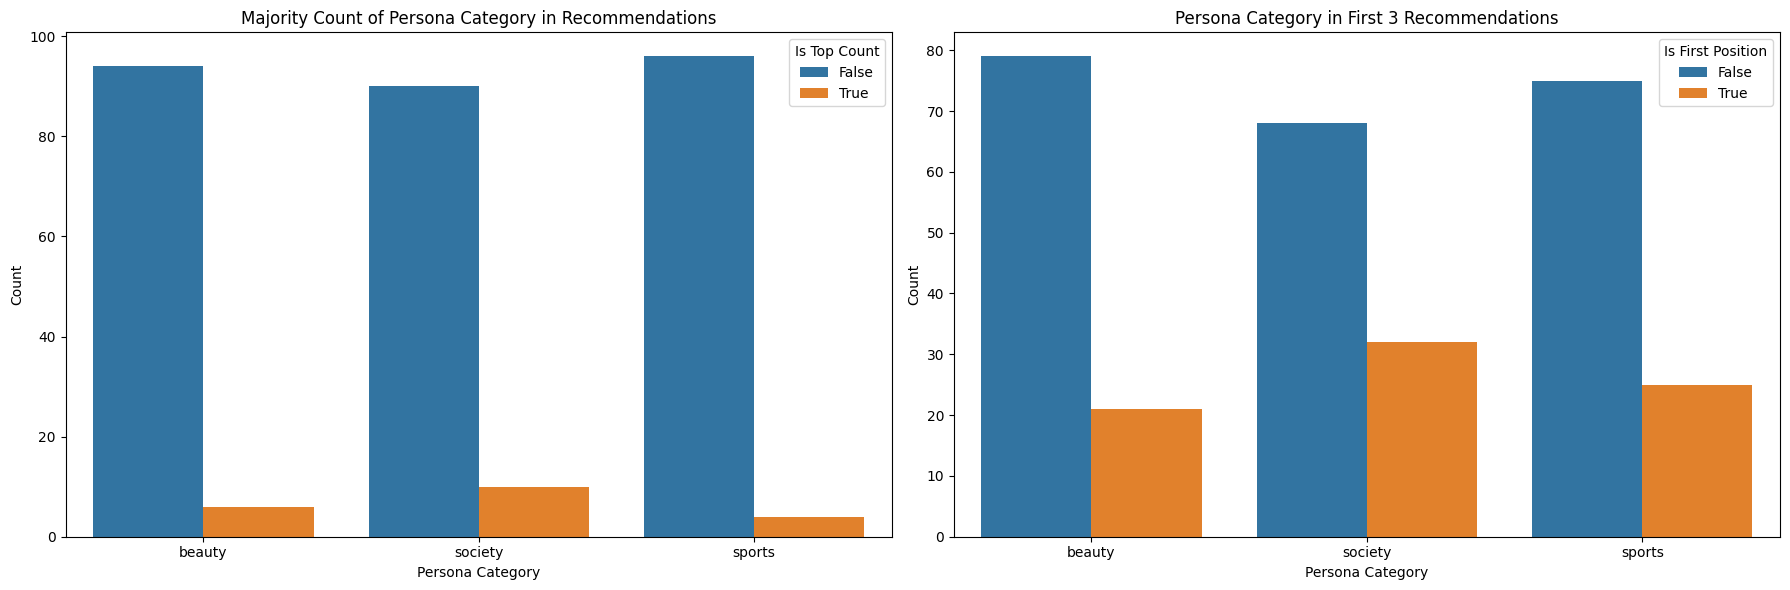

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.countplot(x='persona_category', hue='isMajorityCount_persona', data=df_filtered, ax=axes[0])
axes[0].set_title('Majority Count of Persona Category in Recommendations')
axes[0].set_xlabel('Persona Category')
axes[0].set_ylabel('Count')
axes[0].legend(title='Is Top Count')

sns.countplot(x='persona_category', hue='isFirst3Position_persona', data=df_filtered, ax=axes[1])
axes[1].set_title('Persona Category in First 3 Recommendations')
axes[1].set_xlabel('Persona Category')
axes[1].set_ylabel('Count')
axes[1].legend(title='Is First Position')

plt.tight_layout()
plt.show()

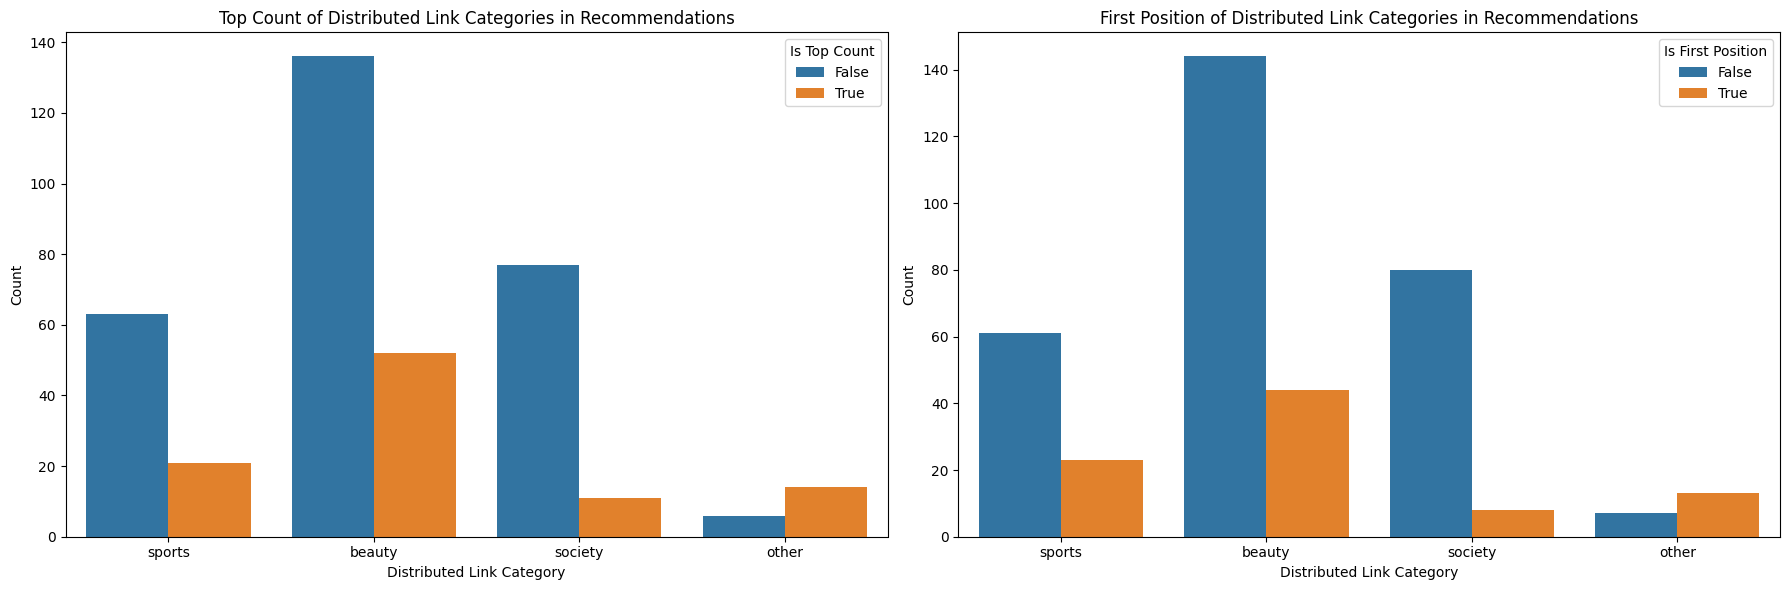

In [51]:
# Bar graph for top count and first position metrics for distributed link categories
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top Count Analysis for Distributed Link
sns.countplot(x='distributed_link_category', hue='isTopCount_dst', data=df_categorized, ax=axes[0])
axes[0].set_title('Top Count of Distributed Link Categories in Recommendations')
axes[0].set_xlabel('Distributed Link Category')
axes[0].set_ylabel('Count')
axes[0].legend(title='Is Top Count')

# First Position Analysis for Distributed Link
sns.countplot(x='distributed_link_category', hue='isFirstPosition_dst', data=df_categorized, ax=axes[1])
axes[1].set_title('First Position of Distributed Link Categories in Recommendations')
axes[1].set_xlabel('Distributed Link Category')
axes[1].set_ylabel('Count')
axes[1].legend(title='Is First Position')

plt.tight_layout()
plt.show()